In [1]:
pip install numpy scikit-fuzzy

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


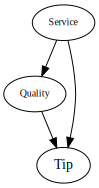

In [4]:
# The DAG representing the causal relatioships between Service, Quality, and Tip
import matplotlib.pyplot as plt
import graphviz

names = [
   "Service",
   "Quality",
]

g = graphviz.Digraph()
for name in names:
    g.node(name, fontsize="10")

g.edge("Quality", "Tip")
g.edge("Service", "Tip")
g.edge("Service", "Quality")
g

In [5]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import random
from mpl_toolkits.mplot3d import Axes3D
import itertools


np.random.seed(42)
# Range of quality and service scores
step = 0.1
quality_range = np.arange(0, 10 + step, step)
service_range = np.arange(0, 10 + step, step)

# Create fuzzy input variables
quality = ctrl.Antecedent(quality_range, 'quality')
service = ctrl.Antecedent(service_range, 'service')
# Auto-membership function population
quality.automf(3)
service.automf(3)

tip = ctrl.Consequent(np.arange(0, 25 + step, step), 'tip')

# Custom membership functions for output variable
tip['low'] = fuzz.trimf(tip.universe, [0, 0, 12.5])
tip['medium'] = fuzz.trimf(tip.universe, [0, 12.5, 25])
tip['high'] = fuzz.trimf(tip.universe, [12.5, 25, 25])

# Define the rules
rules, rule1, rule2, rule3 = [[], [], [], []]

rule1.append(ctrl.Rule(quality['poor'] | service['poor'], tip['low']))
rule1.append(ctrl.Rule(quality['poor'] | service['poor'], tip['medium']))

rule2.append(ctrl.Rule(service['average'], tip['medium']))
rule2.append(ctrl.Rule(service['average'], tip['high']))

rule3.append(ctrl.Rule(service['good'] | quality['good'], tip['high']))
rule3.append(ctrl.Rule(service['good'] | quality['good'], tip['medium']))

rules.append(rule1)
rules.append(rule2)
rules.append(rule3)

indexed_rules = [list(enumerate(rule)) for rule in rules]

# Probabilities of Rules; Here we have three pairs of rules as above,
# and  prob[i][j] means the probability of observing the jth rule in the ith pair.

probs = [[0.7, 0.3], [0.7, 0.3], [0.7, 0.3]]
def simulate_tipping(quality_range, service_range):
    np.random.seed(42)
    results = np.zeros((len(quality_range), len(service_range)))
    for i, q in enumerate(quality_range):
      for j, s in enumerate(service_range):
        expected_tip = 0
        for rule in itertools.product(*indexed_rules):
          indices = tuple(index for index, value in rule)
          values = tuple(value for index, value in rule)
          tipping_ctrl = ctrl.ControlSystem([rules[0][indices[0]], rules[1][indices[1]], rules[2][indices[2]]])
          tipping = ctrl.ControlSystemSimulation(tipping_ctrl)
          tipping.input['quality'] = q
          tipping.input['service'] = s
          tipping.compute()
          expected_tip += tipping.output['tip'] * probs[0][indices[0]] * probs[1][indices[1]] * probs[2][indices[2]]
        results[i, j] = expected_tip
    return np.round(results,5)


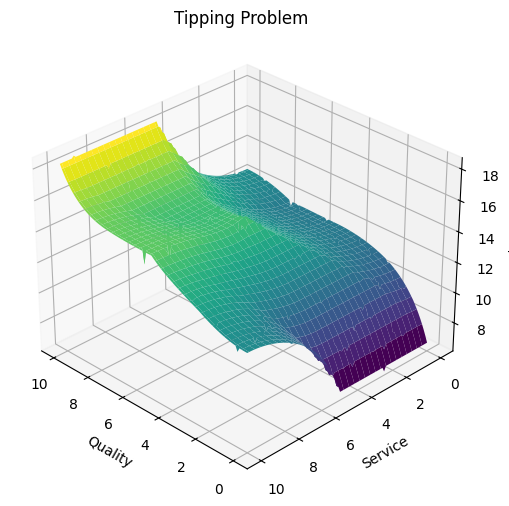

In [6]:
np.random.seed(42)

# Simulate
results = simulate_tipping(quality_range, service_range)

# Prepare meshgrid for plotting
Q, S = np.meshgrid(quality_range, service_range)

# Plot settings
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': '3d'})

# Plot each method
surf = ax.plot_surface(Q, S, results, cmap='viridis')
ax.set_xlabel('Quality')
ax.set_ylabel('Service')
ax.set_zlabel('Tip')
ax.set_title('Tipping Problem')
ax.view_init(elev=30, azim=135)
plt.show()

In [7]:
np.random.seed(42)

# Parameters for the service sample
sample_size = 1000
num_elements = len(service_range)

# Generate a normal distribution 
indices = np.arange(num_elements)
mean = 7 / step
std_dev = 2 / step

num_digits_step = len(str(step).split('.')[-1])

# Compute probabilities for each index
probabilities = np.exp(-0.5 * ((indices - mean) / std_dev) ** 2)
probabilities /= probabilities.sum()  # Normalizing to make the sum of probabilities 1
# Sample from the data list according to the computed probabilities
sampled_service = list(np.round(np.random.choice(service_range, size=sample_size, replace=True, p=probabilities),num_digits_step))

In [8]:
# Calculating E(T(q)) = E(T|do(q))

def expected_T_given_do(q):
  np.random.seed(42)
  total_tip = 0
  for s in sampled_service:
    total_tip += simulate_tipping([q], [s])[0][0] 
  return total_tip / sample_size 

In [9]:
# Estimating the FATE of quality on tip

import scipy.integrate as spi

def low(q):
  if 0 <= q <= 5:
    return -0.2*(q-5)
  else:
    return 0

def high(q):
  if 5 <= q <= 10:
    return 0.2*(q - 5)
  else:
    return 0

norm_low, _ = spi.quad(low, 0, 10)
norm_high, _ = spi.quad(high, 0, 10)

def integrand_low(q):
  np.random.seed(42)
  return (expected_T_given_do(q) * low(q))/norm_low

def integrand_high(q):
  np.random.seed(42)
  return (expected_T_given_do(q) * high(q))/norm_high


expected_low = 0
expected_high = 0
for q in quality_range:
    expected_low += integrand_low(q) * step
    expected_high += integrand_high(q) * step
FATE = expected_high - expected_low
print('FATE = ', FATE)

FATE =  3.025132463303988


In [10]:
# Estimating the NFATE of quality on tip

denominator = 0
for point_1 in quality_range:
  for point_2 in quality_range:
    denominator += (point_2  -  point_1) * low(point_1) * high(point_2) * (step**2)
denominator = denominator/(norm_low * norm_high)

NFATE = FATE/denominator
print('NFATE = ', NFATE)

NFATE =  0.43183112121347045


In [11]:
# Calculating the GFATE_l^h of quality on tip

from math import pi, sqrt, exp
import scipy.integrate as spi

np.random.seed(42)

mu_quality, sigma_quality = 5, 2

def density_quality(q):
  return (1/((sqrt(2*pi))*sigma_quality))*exp(-((q-mu_quality)**2)/(2*(sigma_quality**2)))

def generalized_low(q):
  return low(q) * density_quality(q)
def generalized_high(q):
  return high(q) * density_quality(q)

norm_generalized_low, _ = spi.quad(generalized_low, 0, 10)
norm_generalized_high, _ = spi.quad(generalized_high, 0, 10)

def generalized_integrand_low(q):
  return expected_T_given_do(q) * low(q) * density_quality(q)/norm_generalized_low

def generalized_integrand_high(q):
  return expected_T_given_do(q) * high(q) * density_quality(q)/norm_generalized_high

generalized_expected_low = 0
generalized_expected_high = 0
for point in quality_range:
    generalized_expected_low += generalized_integrand_low(point) * step
    generalized_expected_high += generalized_integrand_high(point) * step
GFATE = generalized_expected_high - generalized_expected_low

print('GFATE = ', GFATE)

GFATE =  2.2083089445711277


In [12]:
np.random.seed(42)

# Estimating the NGFATE of food quality on tip
denominator = 0
for point_1 in quality_range:
  for point_2 in quality_range:
    denominator += (point_2  -  point_1) * low(point_1) * high(point_2) * (step**2)
denominator = denominator/(norm_low * norm_high)

NGFATE = GFATE/denominator
print('NGFATE = ', NGFATE)

NGFATE =  0.3152313292352048
